## Prediction of Daily PM10 and PM2.5

### Importing Data

The particulate matter data show some differences each other, on one hand the PM2.5 present fewer input variables as well some different type of variables if we compare these data with PM10.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from scipy.io import loadmat
from sklearn import preprocessing

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



In [2]:
#Reading data and naming Columns
PM25data=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
PM10data=loadmat('data_Polish.mat')
PM10data=pd.DataFrame.from_dict(PM10data['x'])
PM10data.columns = ['PM_10','SO2','NO_2','OZON','WIND_SPEED', 'WIND_DIR', 'TEMP', 'PROM_SLON', 'WILGOT', 'WIND_X', 'WIND_Y']

### NAN Values in datasets 

There are some NaN numbers in the PM2.5 data, it can be seen in the following two cells. On possible workarround may be to interpolate the missing values with the known ones and ensure all dataset will have defined values.

The interpolation is then carried out, nevertheless, the first 24 data points are still missing, thus they are removed completly.

In [3]:
#Interpolation and removing NAN Values from PM2.5 data, new data index is set. 
PM25_interpolate=PM25data['pm2.5'].fillna(method='ffill')
PM25data_clean=PM25data
PM25data_clean['pm2.5']=PM25_interpolate
PM25data_clean=PM25data_clean[24:]
i_PM10 = pd.date_range('2006-01-01', periods=len(PM10data), freq='H')
PM10data.index=i_PM10
PM25data_clean=PM25data_clean.set_index(['year', 'month','day','hour'])
PM25data=PM25data_clean
PM25data.drop(['No'], axis=1, inplace=True)
PM25data['new_idx']=pd.to_datetime(PM25data.index.to_frame())
PM25data.set_index('new_idx', inplace=True)

In [4]:
#Some useful information from the whole PM10 daily dataset
PM10data.describe()

,PM_10,SO2,NO_2,OZON,WIND_SPEED,WIND_DIR,TEMP,PROM_SLON,WILGOT,WIND_X,WIND_Y
count,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000,36831.000000
mean,33.560769,9.889465,24.821205,48.430007,1.705954,196.621949,8.708827,118.966170,74.903179,0.006133,-0.003876
std,26.244108,8.783450,17.852122,31.095223,0.798239,91.479774,9.151818,202.522871,19.766576,1.330480,1.333160
min,0.700000,0.700000,0.400000,0.100000,0.140000,0.000000,-26.000000,0.000000,16.000000,-5.311197,-5.577682
25%,17.250000,4.500000,12.500000,24.100000,1.110000,128.000000,1.300000,0.000000,61.000000,-0.947358,-0.950281
50%,27.100000,7.100000,20.100000,44.900000,1.610000,179.000000,8.900000,3.000000,80.000000,-0.005753,-0.002637
75%,42.300000,12.100000,31.700000,68.200000,2.200000,274.000000,15.600000,148.000000,91.000000,0.953193,0.944142
max,414.900000,157.800000,203.800000,189.100000,5.840000,360.000000,35.000000,940.000000,100.000000,4.934154,4.929808


In [5]:
#Some useful information from the whole PM2.5 daily dataset
PM25data.describe()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,97.784018,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,91.398542,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,136.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


### Creating Daily Regressors

The daily regressors are now generated calculating the mean of each variable every 24 hours, the vales from non numeric variables are removed from the newly created dataframe. The boxplots show higher variability in the PM2.5 data, in both data however, several outliers points appear. Then, the datasets are scaled in order to have be processed by the models. 

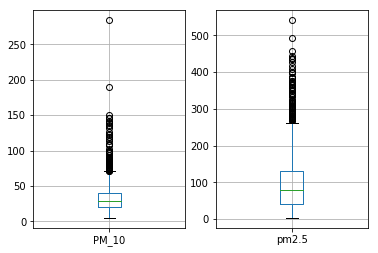

In [6]:
#Boxplots of Daily PMs
PM10_daily=PM10data.resample('d').mean()
PM25_daily=PM25data.resample('d').mean()
fig, axs = plt.subplots(1,2)
boxplot1 = PM10_daily.boxplot(column=['PM_10'], ax=axs[0])
boxplot2 = PM25_daily.boxplot(column=['pm2.5'], ax=axs[1])

In [7]:
#Standardization of data
X_PM10=PM10_daily.values
X_PM25=PM25_daily.values
scaler_X_PM10 = preprocessing.StandardScaler().fit(X_PM10)
scaler_X_PM25 = preprocessing.StandardScaler().fit(X_PM25)

#Other type of normalization=>
#MinMaxScaler #minmax_scale #MaxAbsScaler #StandardScaler #RobustScaler 
#Normalizer #QuantileTransformer #PowerTransformer
X_PM10_scaled=scaler_X_PM10.transform(X_PM10)
X_PM25_scaled=scaler_X_PM25.transform(X_PM25)

In [8]:
#First Column is Target Variable, the rest are the features
X_PM25=X_PM25_scaled[:,1:]
y_PM25=X_PM25_scaled[:,0]

X_PM10=X_PM10_scaled[:,1:]
y_PM10=X_PM10_scaled[:,0]

### Splitting data into Training and Testing samples - Cross-Validation

The data is split leaving some part out of the process, this part will be used to evualuate the performance of predictions. It is usually selected arround 70% or 80% of samples for learning the model.

In [9]:
#Percentage of Testing Data, Remainder is training data
splitter_PM10=0.10 
splitter_PM25=0.10 

#PCA Variance retained
sigma2_PM10=0.999
sigma2_PM25=0.999

In [10]:
#Splitting training and testing
X_train_PM10, X_test_PM10, y_train_PM10, y_test_PM10 = train_test_split(X_PM10, y_PM10, test_size=splitter_PM10, shuffle='True')
X_train_PM25, X_test_PM25, y_train_PM25, y_test_PM25 = train_test_split(X_PM25, y_PM25, test_size=splitter_PM25, shuffle='True')

In [11]:
#PCA PM10
pca_PM10 = PCA(sigma2_PM10)
pca_PM10 = pca_PM10.fit_transform(X_train_PM10)
principalComponents_PM10 = pd.DataFrame(data = pca_PM10)
print(len(principalComponents_PM10))

#PCA PM25
pca_PM25 = PCA(sigma2_PM25)
pca_PM25 = pca_PM25.fit_transform(X_train_PM25)
principalComponents_PM25 = pd.DataFrame(data = pca_PM25)

1381


In [ ]:
# Step Wise

???

In [ ]:
# Hyperparameter Optimization

In [12]:
#https://scikit-learn.org/stable/modules/grid_search.html
#https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa

nhn_range=[8,10,12,14,16,18]
mae_train_PM10=np.empty(len(nhn_range))
mae_test_PM10=np.empty(len(nhn_range))
k=0
for nhn in nhn_range:  
    mlp = MLPRegressor(hidden_layer_sizes=(nhn,), activation='tanh', 
                       solver='adam', shuffle=False, random_state=42, 
                       max_iter=20000, momentum=0.7, early_stopping=True, 
                       validation_fraction=0.15)
    mlp.fit(X_train_PM10,y_train_PM10)
    
    y_predict_train_PM10 = mlp.predict(X_train_PM10)
    y_predict_test_PM10 = mlp.predict(X_test_PM10)
    
    
    mae_train_PM10[k]=median_absolute_error(y_train_PM10, y_predict_train_PM10)
    mae_test_PM10[k]=median_absolute_error(y_test_PM10,  y_predict_test_PM10)
    k=k+1
    

In [20]:
parameter_space = {
    'hidden_layer_sizes': [(64,64,64),  (128,128,128)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-2, cv=3)
clf.fit(X_train_PM10, y_train_PM10)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='tanh', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=True, epsilon=1e-08,
                                    hidden_layer_sizes=(18,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=20000,
                                    momentum=0.7, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_stat...
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.15, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.000

In [23]:
keys=clf.best_params_
keys

{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (64, 64, 64),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [24]:
y_predict_PM10=clf.predict(X_test_PM10)

In [25]:
median_absolute_error(y_predict_PM10,y_test_PM10)

0.24068474605805074